## Семинар 9: "LSTM"

ФИО: Токаева Александра Александровна

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset

from torch.autograd import Variable
from tqdm import tqdm
import pandas as pd

%matplotlib inline

#from torch.optim.lr_scheduler import StepLR

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.randn(input_size, self.gate_size))
        
        self.W_h = nn.Parameter(torch.randn(hidden_size, self.gate_size))
        
        self.b = nn.Parameter(torch.randn(self.gate_size))
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        batch_size = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, batch_size, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(batch_size, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c) #batch_size*hidden_size
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

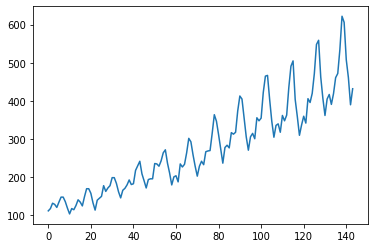

In [24]:
%matplotlib inline
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [25]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(144, 1)

In [26]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [28]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward+1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        #dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])
        dataY.append(dataset[i + look_forward : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [36]:
class LSTM_PlusLinear(nn.Module):
    def __init__(self,input_size=1,hidden_size=1):
        super(LSTM_PlusLinear,self).__init__()
        self.lstm=LSTM(input_size,hidden_size)
        self.hidden_size=hidden_size
        self.linear=nn.Linear(hidden_size,1)
    def forward(self,tek_batch_x,h,c):
        y,(h,c)=self.lstm.forward(tek_batch_x,(h,c))
        return self.linear.forward(y),h,c

In [43]:
# Пример подготовленных данных

look_back = 30
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
batch_size=32
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)



hidden_size=30
Net=LSTM_PlusLinear(input_size=1,hidden_size=hidden_size) #here seq_len=look_back,batch_size=1, input_size=1,hidden_size=1,
loss_neuron=torch.nn.MSELoss()
optimizer=torch.optim.Adam(Net.parameters(), lr=0.001)
h=torch.zeros(batch_size, hidden_size,requires_grad=True)
c=torch.zeros(batch_size, hidden_size,requires_grad=True)
for ep in tqdm(range(2000)):
    mas_losses=[]
    for tek_batch_x,tek_batch_y in train_dataloader: #tek_batch_x(7,1,5),needs (5,7,1)
        Net.zero_grad()
        tek_batch_x=tek_batch_x.permute(2,0,1)
        h=torch.zeros(tek_batch_x.size(1), hidden_size,requires_grad=True)
        c=torch.zeros(tek_batch_x.size(1), hidden_size,requires_grad=True)
        y,h,c=Net.forward(tek_batch_x,h,c)
        tek_loss=loss_neuron(y.permute(1,2,0).view(-1,look_back),tek_batch_y.view(-1,look_back))
        mas_losses.append(tek_loss.item())
        tek_loss.backward()
        optimizer.step()
        #h = h.detach()
        #c = c.detach()
    if (ep%100==0): print(np.mean(mas_losses))

  0%|          | 2/2000 [00:00<04:47,  6.94it/s]

0.01941269605110089


  5%|▌         | 102/2000 [00:07<02:28, 12.77it/s]

0.003842122464751204


 10%|█         | 201/2000 [00:15<02:26, 12.29it/s]

0.0028297421522438526


 15%|█▌        | 303/2000 [00:23<01:52, 15.12it/s]

0.0020700975243623057


 20%|██        | 403/2000 [00:30<01:50, 14.46it/s]

0.0017362832246969144


 25%|██▌       | 503/2000 [00:36<01:34, 15.78it/s]

0.001503538223914802


 30%|███       | 603/2000 [00:44<01:44, 13.38it/s]

0.001381942614292105


 35%|███▌      | 703/2000 [00:51<01:41, 12.77it/s]

0.0011564105516299605


 40%|████      | 802/2000 [00:59<03:34,  5.60it/s]

0.0009690865602654716


 45%|████▌     | 903/2000 [01:10<01:28, 12.45it/s]

0.0008727023766065637


 50%|█████     | 1003/2000 [01:17<01:07, 14.85it/s]

0.0008035317975251625


 55%|█████▌    | 1103/2000 [01:25<00:58, 15.23it/s]

0.0007485548267140985


 60%|██████    | 1203/2000 [01:32<01:07, 11.85it/s]

0.0007037612182709078


 65%|██████▌   | 1303/2000 [01:39<00:47, 14.78it/s]

0.0006578870816156268


 70%|███████   | 1403/2000 [01:46<00:38, 15.60it/s]

0.000615400587169764


 75%|███████▌  | 1503/2000 [01:54<00:37, 13.26it/s]

0.0005884313820085177


 80%|████████  | 1603/2000 [02:01<00:26, 14.83it/s]

0.0005536385482021918


 85%|████████▌ | 1703/2000 [02:08<00:19, 15.59it/s]

0.0005246345487345631


 90%|█████████ | 1802/2000 [02:16<00:15, 12.57it/s]

0.00048636607728743303


 95%|█████████▌| 1904/2000 [02:23<00:06, 15.65it/s]

0.00048167797406980145


100%|██████████| 2000/2000 [02:30<00:00, 13.29it/s]


In [ ]:
#смотрим, насколько хорошо мы научились предсказывать 1 число по 30 предыдущим

0.07432302811907397


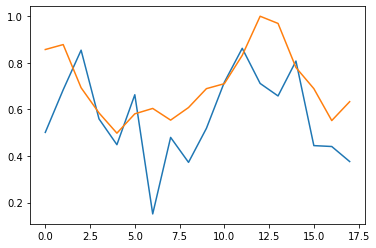

In [47]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
batch_size=1 #мы в тесте собираемся по одной последовательности подавать
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)

#сейчас батч размера 1, а в обучении он был 89, поэтому сейчас надо h заменить 

mas_test_losses=[]
otv=[]
for tek_batch_x,tek_batch_y in test_dataloader: #tek_batch_x(7,1,5),needs (5,7,1)
    tek_batch_x=tek_batch_x.permute(2,0,1)
    #print(tek_batch_x.shape)
    h=torch.zeros(batch_size, hidden_size)
    c=torch.zeros(batch_size, hidden_size) #для каждой новой последовательности h генерим рандомно
    y,h,c=Net.forward(tek_batch_x,h,c)
    #print(h.shape)
    otv.append(y[-1].item())
    tek_loss=loss_neuron(y.permute(1,2,0)[0],tek_batch_y.view(-1,look_back))
    mas_test_losses.append(tek_loss.item())
    y.detach()
print(np.mean(mas_test_losses))

plt.plot(otv)
plt.plot(testY[:,-1])
plt.show()

In [ ]:
#Теперь предсказываем весь тест: новую одну предсказанную точку считаем настоящей и сдвигаем рамку на 1 вперед

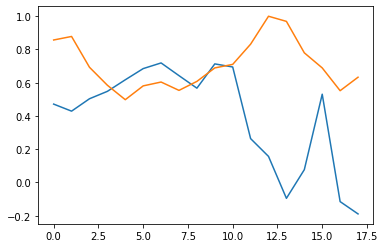

In [49]:
otvNew=[]
tek_x=list(trainX[-1][0][1:])
tek_x.append(trainY[-1][0])
tek_x=torch.Tensor(tek_x)
batch_size=1
h=torch.zeros(batch_size, hidden_size) #только стартовые h и c делаем рандомными, а дальше они по цепочке переезжают
c=torch.zeros(batch_size, hidden_size)
for i in range(len(testX)):
    tek_x=tek_x.view(look_back,1,1)
    h=torch.zeros(batch_size, hidden_size)
    c=torch.zeros(batch_size, hidden_size) 
    y,h,c=Net.forward(tek_x,h,c)
    otvNew.append(y[-1].item())
    tek_x=list(tek_x.detach().numpy()[1:])
    tek_x.append(y[-1])
    tek_x=torch.Tensor(tek_x)
    #print(tek_x)
#print(otvNew)
plt.plot(otvNew)
plt.plot(testY[:,-1])
plt.show()

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/db8f882eee2b4fbd9936a8c51b62245c 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 3 декабря 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [50]:
def mape(a,b):
    return np.mean((np.abs((a-b)/a))*100)

In [51]:
df=pd.read_csv("train.csv")
df.head(5)

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490


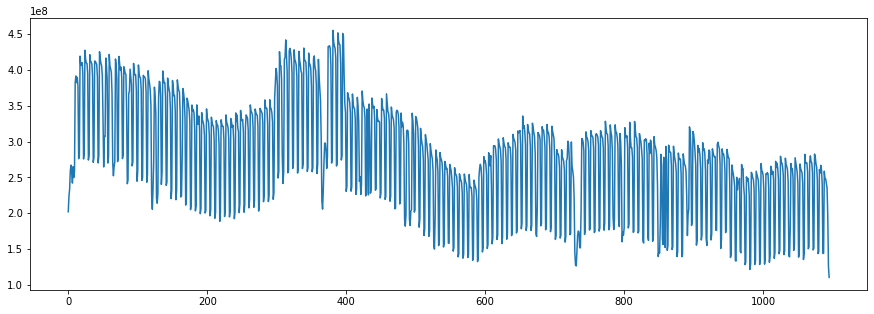

In [52]:
plt.figure(figsize=(15,5))
plt.plot(df['hits'])
plt.show()

In [54]:
dataset = df['hits'].values.reshape(-1,1)
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset.shape)
train_size = int(len(dataset) * 1)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(1096, 1)
1096 0


In [ ]:
#теперь добавляем линейный слой на выходе

(1066, 1, 30)


  0%|          | 1/3000 [00:00<19:01,  2.63it/s]

0.1614176332950592


  3%|▎         | 101/3000 [00:23<10:43,  4.51it/s]

0.02942209504544735


  7%|▋         | 201/3000 [00:48<10:57,  4.26it/s]

0.021884232759475708


 10%|█         | 301/3000 [01:12<11:28,  3.92it/s]

0.016587551683187485


 13%|█▎        | 401/3000 [01:35<09:59,  4.33it/s]

0.01357853040099144


 17%|█▋        | 501/3000 [01:57<09:06,  4.57it/s]

0.01162850484251976


 20%|██        | 601/3000 [02:19<08:54,  4.49it/s]

0.009974786080420017


 23%|██▎       | 701/3000 [02:41<07:58,  4.81it/s]

0.009164830669760704


 27%|██▋       | 801/3000 [03:02<07:30,  4.88it/s]

0.008636887185275555


 30%|███       | 901/3000 [03:24<07:23,  4.73it/s]

0.008196762762963772


 33%|███▎      | 1001/3000 [03:46<06:43,  4.96it/s]

0.007819250226020813


 37%|███▋      | 1102/3000 [04:07<06:23,  4.95it/s]

0.007494770921766758


 40%|████      | 1202/3000 [04:29<06:02,  4.96it/s]

0.0072127440944314


 43%|████▎     | 1301/3000 [04:50<05:46,  4.90it/s]

0.006969182752072811


 47%|████▋     | 1401/3000 [05:12<06:28,  4.11it/s]

0.006761013995856047


 50%|█████     | 1501/3000 [05:35<05:54,  4.23it/s]

0.006582094356417656


 53%|█████▎    | 1601/3000 [05:59<05:43,  4.08it/s]

0.006422978360205889


 57%|█████▋    | 1701/3000 [06:22<05:04,  4.26it/s]

0.0062749325297772884


 60%|██████    | 1801/3000 [06:45<04:34,  4.37it/s]

0.006133518647402525


 63%|██████▎   | 1901/3000 [07:09<04:05,  4.48it/s]

0.005997808184474707


 67%|██████▋   | 2002/3000 [07:38<03:19,  5.01it/s]

0.005867040250450373


 70%|███████   | 2101/3000 [07:59<03:01,  4.95it/s]

0.00574317155405879


 73%|███████▎  | 2201/3000 [08:21<03:06,  4.29it/s]

0.005627927836030722


 77%|███████▋  | 2302/3000 [08:43<02:18,  5.04it/s]

0.005517803598195314


 80%|████████  | 2402/3000 [09:04<01:58,  5.05it/s]

0.0054092854261398315


 83%|████████▎ | 2501/3000 [09:24<01:37,  5.11it/s]

0.005303254816681147


 87%|████████▋ | 2602/3000 [09:45<01:19,  5.03it/s]

0.005201076157391071


 90%|█████████ | 2702/3000 [10:06<00:58,  5.14it/s]

0.0051032183691859245


 93%|█████████▎| 2802/3000 [10:26<00:38,  5.16it/s]

0.005009413231164217


 97%|█████████▋| 2902/3000 [10:47<00:19,  5.12it/s]

0.004920363891869783


100%|██████████| 3000/3000 [11:07<00:00,  4.49it/s]


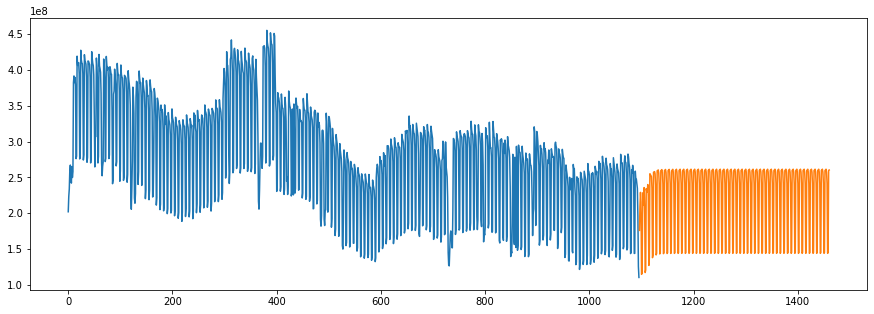

In [75]:
look_back=32
look_forward=1
trainX, trainY=create_dataset(train,look_back,look_forward)
testX, testY=create_dataset(test,look_back,look_forward)

trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
print(trainX.shape)

train_dataset=TensorDataset(torch.from_numpy(trainX),torch.from_numpy(trainY))

batch_size=1091
train_dataloader=DataLoader(train_dataset,batch_size=batch_size)

hidden_size=30
Net=LSTM_PlusLinear(input_size=1,hidden_size=hidden_size)
loss_neuron=torch.nn.MSELoss()
optimizer=torch.optim.Adam(Net.parameters(), lr=0.001)
h=torch.zeros(batch_size,hidden_size,requires_grad=True)
c=torch.zeros(batch_size,hidden_size,requires_grad=True)
for ep in tqdm(range(3000)):
    mas_losses=[]
    for tek_batch_x,tek_batch_y in train_dataloader: #tek_batch_x(7,1,5),needs (5,7,1)
        Net.zero_grad()
        tek_batch_x=tek_batch_x.permute(2,0,1)
        h=torch.zeros(tek_batch_x.size(1), hidden_size,requires_grad=True)
        c=torch.zeros(tek_batch_x.size(1), hidden_size,requires_grad=True)
        #print(y.shape,tek_batch_y.shape)
        y,h,c=Net.forward(tek_batch_x,h,c)
        #print(y.permute(1,2,0).shape,tek_batch_y.shape)
        tek_loss=loss_neuron(y.permute(1,2,0).view(-1,look_back),tek_batch_y.view(-1,look_back))
        mas_losses.append(tek_loss.item())
        tek_loss.backward()
        optimizer.step()
        y=y.detach()
    if (ep%100==0):print(np.mean(mas_losses))
        
        
        
test_df=pd.read_csv("sample_submission.csv")
#print(test_df.shape)

otv=[]
tek_x=list(trainX[-1][0][1:])
tek_x.append(trainY[-1][0])
tek_x=torch.Tensor(tek_x)
batch_size=1
h=torch.zeros(batch_size, hidden_size)
c=torch.zeros(batch_size, hidden_size)
for i in range(365):
    tek_x=tek_x.view(look_back,batch_size,1)
    h=torch.zeros(batch_size, hidden_size)
    c=torch.zeros(batch_size, hidden_size)
    y,h,c=Net.forward(tek_x,h,c)
    otv.append(y.detach().numpy()[-1][0])
    tek_x=list(tek_x.detach().numpy()[1:])
    tek_x.append(y[-1])
    tek_x=torch.Tensor(tek_x)
    #print(tek_x)
#print(otv)
#plt.plot(otv)
#plt.show()

otvScaledBack=scaler.inverse_transform(np.array(otv).reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(df['hits'])
plt.plot(np.arange(len(df['hits']),len(df['hits'])+len(otvScaledBack)),otvScaledBack)
plt.show()

In [76]:
otvScaledBack=scaler.inverse_transform(np.array(otv).reshape(-1,1))

In [77]:
test_df=pd.read_csv("sample_submission.csv")
test_df['hits']=otvScaledBack.astype(int)
test_df.head(5)

,date,hits
0,2019-01-01,176027280
1,2019-01-02,210042768
2,2019-01-03,229041200
3,2019-01-04,215379840
4,2019-01-05,114663224


In [78]:
test_df.to_csv("my_submission.csv",index=False)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: